In [127]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [128]:
n = 128
x_1 = np.linspace(0, 1, 2*n+1)  # 256 points between 0 and 1 [256x1]
x_2 = np.linspace(1, 0, 2*n+1)  # 256 points between 1 and 0 [256x1]

X, Y = np.meshgrid(x_1, x_2)

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [129]:
X_v_test = np.hstack((X.flatten(order='F')[:, None], Y.flatten(order='F')[:, None]))

lb = np.array([0, 0])  # lower bound
ub = np.array([1, 1])  # upper bound

r = np.sqrt((X-1/2)**2 + Y**2)
theta = np.arctan2(Y, X-1/2)
theta = np.where(theta < 0, theta + 2*np.pi, theta)
s = r**(1/2) * np.sin(theta/2)
sd = s.flatten('F')[:, None]
R = 1/4
eta = np.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
eta = np.where(r < R/2, 1, eta)
etad = eta.flatten('F')[:, None]
v_sol = np.sin(np.pi * X) * Y**2 * (Y - 1) + eta * s
v_y = Y - Y

v_true = v_sol.flatten('F')[:, None]

# Training Data

In [130]:
def trainingdata(N_v,N_f,N_n):
    
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_v = v_sol[:, 0][:, None]

    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_v = v_sol[:, -1][:, None]

    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_v = v_sol[0, :][:, None]

    bottomedge_x = np.hstack((X[-1, n+1:2*n+1][:, None], Y[-1, n+1:2*n+1][:, None]))
    bottomedge_v = v_sol[-1, n+1:2*n+1][:, None]

    neumann_x = np.hstack((X[-1, 0:n][:, None], Y[-1, 0:n][:, None]))
    neumann_v = v_y[-1, 0:n][:, None]

    all_X_v_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_v_train = np.vstack([leftedge_v, rightedge_v, bottomedge_v, topedge_v])

    # choose random N_v points for training
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False)

    X_v_train = all_X_v_train[idx[0:N_v], :]  # choose indices from  set 'idx' (x,t)
    v_train = all_v_train[idx[0:N_v], :]  # choose corresponding v

    # choose random N_v points for training
    idx2 = np.random.choice(neumann_x.shape[0], N_n, replace=False)

    neumann_x_train = neumann_x[idx2[0:N_n], :]  # choose indices from  set 'idx' (x,t)
    neumann_v_train = neumann_v[idx2[0:N_n], :]  # choose corresponding v

    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    r = np.sqrt((X_v_test[:, 0]-1/2)**2 + X_v_test[:, 1]**2)
    probability = np.where(r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(X_v_test.shape[0], N_f, replace=False, p=probability)
    X_f = X_v_test[idx[0:N_f], :]
    X_f_train = np.vstack((X_f, X_v_train, neumann_x_train))  # append training points to collocation points

    return X_f_train, X_v_train, v_train, neumann_x

# PINN

Creating sequential layers using the class
tf.Module

In [131]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.lagrange1 = torch.autograd.Variable(torch.ones(1).to(device),requires_grad=True)
        self.lagrange2 = torch.autograd.Variable(torch.ones(1).to(device),requires_grad=True)
        self.lagrange3 = torch.autograd.Variable(3*torch.ones(1).to(device),requires_grad=True)
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_v = self.lagrange1*self.loss_function(self.forward(x), y)
                
        return loss_v
    
    def loss_neumann(self,neumann_x, neumann_v):
                
        x_1_f = neumann_x[:,[0]]
        x_2_f = neumann_x[:,[1]]
        
        g = neumann_x.clone()
                        
        g.requires_grad = True
        
        vv = self.forward(g)
                
        v_x = autograd.grad(vv,g,torch.ones([neumann_x.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_2 = v_x[:,[1]]
        
        loss_neumann = self.loss_function(v_x_2, neumann_v)
                
        return loss_neumann
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv = self.forward(g)
                
        v_x = autograd.grad(vv,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                                            
        v_xx = autograd.grad(v_x[:,[0]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy = autograd.grad(v_x[:,[1]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_1 = v_xx[:,[0]]
        v_xx_2 = v_yy[:,[1]]
        
        r = np.sqrt((x_1_f-1/2) ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f-1/2)
        theta = np.where(theta < 0, theta + 2 * np.pi, theta)

        deltap = torch.where(r < R, -(-15.0*r - 196608.0*(r - 0.1875)**5 + 2560.0*(r - 0.1875)**3 + 3.3125)*np.sin(theta/2)
                          /(4*r**1.5) + (0.5*(-15.0*r - 196608.0*(r - 0.1875)**5 + 2560.0*(r - 0.1875)**3 + 3.3125)*
                                         np.sin(theta/2)/r**0.5 + r**0.5*(-983040.0*(r - 0.1875)**4 +
                                                                          7680.0*(r - 0.1875)**2 - 15.0)*np.sin(theta/2)
                                         + r*(-0.25*(-15.0*r - 196608.0*(r - 0.1875)**5
                                                     + 2560.0*(r - 0.1875)**3 + 3.3125)*np.sin(theta/2)/r**1.5
                                              + 1.0*(-983040.0*(r - 0.1875)**4 + 7680.0*(r - 0.1875)**2 - 15.0)
                                              *np.sin(theta/2)/r**0.5 + r**0.5*(15360.0*r
                                                                                - 3932160.0*(r - 0.1875)**3 - 2880.0)
                                              *np.sin(theta/2)))/r, 0)
        deltap = torch.where(r < R / 2, 0, deltap)
        
        F = -np.sin(np.pi * x_1_f) * (-np.pi**2 * x_2_f**2 * (x_2_f-1) + 2 * (3 * x_2_f - 1)) - deltap
        
        f = v_xx_1 + v_xx_2 + F
               
        H = 0.1
        F = torch.where(r >= H, self.lagrange2 * f, f)
        F = torch.where(r < H, self.lagrange3 * f, f)

        loss_f = self.loss_function(f, f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f, neumann_x, neumann_v, sigma):

        loss_v = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        loss_neumann = self.loss_neumann(neumann_x, neumann_v)

        loss = loss_neumann + sigma * loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train, neumann_x, neumann_v, sigma)
        
        #error_vec, _ = PINN.test()
        
        #print(loss_val,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((v-v_pred),2)/torch.linalg.norm(v,2)    # Relative L2 Norm of the error (Vector)
        
        loss_f = self.loss_PDE(X_f_train)
        
        u_pred = v_pred.cpu().detach().numpy()
        
        u_pred = np.reshape(u_pred, (2*n+1, 2*n+1), order='F')
        
        return error_vec, u_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)
tensor(0.2546, grad_fn=<DivBackward0>)
tensor(0.2301, grad_fn=<DivBackward0>)
tensor(0.1155, grad_fn=<DivBackward0>)
tensor(0.0770, grad_fn=<DivBackward0>)
tensor(0.0564, grad_fn=<DivBackward0>)
tensor(0.0440, grad_fn=<DivBackward0>)
Training time: 389.67
sigma: 759.375000
Test Error: 0.04397


C:\Users\HP\AppData\Local\Temp/ipykernel_28420/866499432.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_pred, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_28420/866499432.py:88: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, np.abs(v_sol - u_pred), cmap='jet')


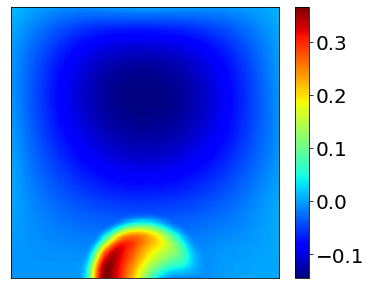

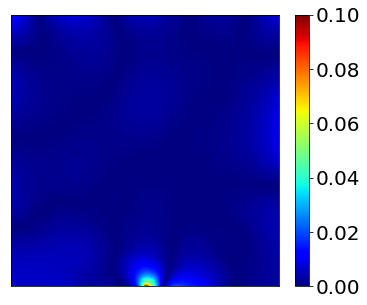

In [132]:
N_v = 800
N_n = 100
N_f = 10000 

X_f_train_np_array, X_v_train_np_array, v_train_np_array, neumann_x_np_array = trainingdata(N_v, N_f, N_n)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
v_train = torch.from_numpy(v_train_np_array).float().to(device)
neumann_x = torch.from_numpy(neumann_x_np_array).float().to(device)
neumann_v = torch.zeros(neumann_x.shape[0],1).to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2,10,10,10,1])

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)
params = list(PINN.parameters())

sigma = 100

start_time = time.time()
error_vec = 1

optimizer = optim.Adam(PINN.parameters(), lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizerl = optim.Adam([PINN.lagrange1], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer2 = optim.Adam([PINN.lagrange2], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer3 = optim.Adam([PINN.lagrange3], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
max_iter = 1000
for i in range(max_iter):
    loss = -PINN.loss(X_v_train, v_train, X_f_train, neumann_x, neumann_v, sigma)
    optimizerl.zero_grad()
    optimizer2.zero_grad() 
    optimizer3.zero_grad()
    loss.backward() 
    loss = PINN.loss(X_v_train, v_train, X_f_train, neumann_x, neumann_v, sigma)
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    optimizerl.step()
    optimizer2.step()
    optimizer3.step()

while sigma<800 and error_vec>0.001:
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1,
                              max_iter = 1000, 
                              max_eval = 2500, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer.step(PINN.closure)
    
    sigma = 1.5 * sigma
    error_vec, _ = PINN.test()
    print(error_vec)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('sigma: %f' %(sigma/1.5))
print('Test Error: %.5f'  % (error_vec))

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(X, Y, u_pred, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred-2-SAPINN',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(X, Y, np.abs(v_sol - u_pred), cmap='jet')
h=plt.colorbar()
h.mappable.set_clim(0, 0.1)
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('error-2-SAPINN',bbox_inches='tight')
plt.show()